In [1]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

In [2]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [3]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

In [4]:
#Load the data.
#false_positives = pd.read_json(join(data_path, 'false_positives.json'))
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
#true_negatives = pd.read_json(join(data_path, 'true_negatives.json'))

In [5]:
print('true_positives: ',ship_positives.shape)
#print('false_positives:',false_positives.shape) # not corresponding to the data sescribtion, should be checked out
#print('true_negatives: ',true_negatives.shape)

true_positives:  (1, 1596)


In [6]:
# define function for data extraction
def data_extract(data_frame, dict_key):
    """Extract data from json file and 
    transform it as ndarray"""
    #dict_key: should be text
    
    list_of_bands = []
    for i in range(data_frame.shape[1]):
        single_arr = data_frame[i][0][dict_key]
        
        # we need to recover the incidence angle as a band image
        if dict_key == 'incidenceangle':
            band = np.full((21, 21), single_arr)
        else:
            band = single_arr
            
        list_of_bands.append(band)

    return np.array(list_of_bands)

# define function form image re-sizing
dsize = (80, 80)
def im_resize(img,interpolation):
    resized = cv2.resize(img, dsize=dsize, interpolation=interpolation) #cv2.INTER_CUBIC #cv2.INTER_NEAREST
    return resized

### Data extracton and resizing

In [8]:
# get true positive data
ship_positive_data = data_extract(ship_positives, 'windowfu')
# ship_positive_target = data_extract(ship_positives, 'validais')
ship_positive_angle = data_extract(ship_positives, 'incidenceangle')
# define ship target class as "2" for image class
# ship_positive_target = np.full(ship_positives.shape[1], 2) 
# pixel based classes 
ship_positive_target = data_extract(ship_positives, 'windowgt')

# Resize the images
ship_positive_80 = np.array([im_resize(image, interpolation=cv2.INTER_NEAREST) for image in ship_positive_data])
ship_positive_angle = np.array([im_resize(image, interpolation=cv2.INTER_NEAREST) for image in ship_positive_angle])
# combine data and angle into 2 band images
data = np.concatenate([ship_positive_80[:, :, :, np.newaxis], ship_positive_angle[:, :, :, np.newaxis]], axis=-1)

#data = ship_positive_80
target = np.array([im_resize(image, interpolation=cv2.INTER_NEAREST) for image in ship_positive_target])
target = np.array(target[:,:,:,np.newaxis])

### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

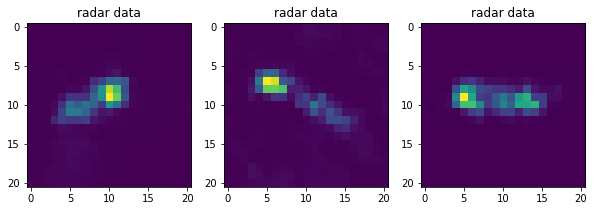

In [9]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(ship_positive_data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(ship_positive_data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(ship_positive_data[43,:,:])
axarr[2].set_title('radar data')

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

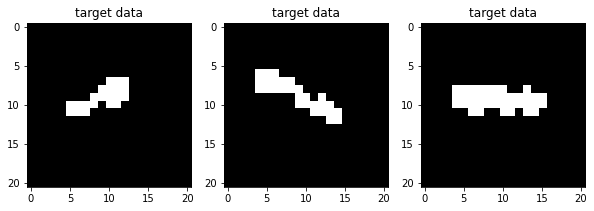

In [9]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(ship_positive_target[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(ship_positive_target[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(ship_positive_target[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Resized (80x80) 

Text(0.5, 1.0, 'ship')

<Figure size 432x288 with 0 Axes>

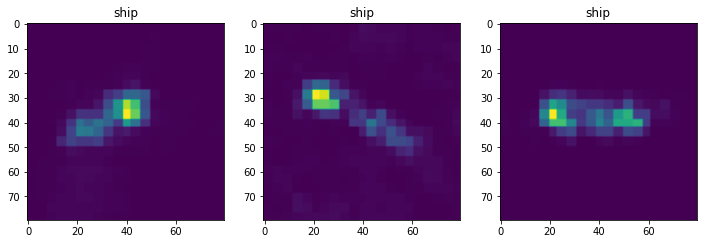

In [10]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(12, 12)) 

# use the created array to output your multiple images.
axarr[0].imshow(ship_positive_80[1200,:,:])
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_80[14,:,:])  
axarr[1].set_title('ship')
axarr[2].imshow(ship_positive_80[43,:,:])
axarr[2].set_title('ship')

In [18]:
from sklearn.model_selection import train_test_split

# Define the data split strategy
def data_split(data, target, train_size, test_size): 
    ''' Train-validation-test split'''

    # split data to get the initial training test split
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1, 
                                                train_size=train_size) # no stratification here
    
    # split data to get train validation split
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split( X_train, y_train, random_state=1,
                                                test_size = valid_size) 
    
    return  X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test

# define split parameters
train_size = 0.75
valid_size = 0.20

X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test = data_split(data, target, train_size, valid_size )
print(f'data split: \nTrain: \t    {X_train_cv.shape[0]} \nValidation: {X_valid.shape[0]} \nTest: \t    {X_test.shape[0]}')

data split: 
Train: 	    957 
Validation: 240 
Test: 	    399


In [19]:
print(data.shape)
print(target.shape)

(1596, 80, 80, 2)
(1596, 80, 80, 1)


In [12]:
target.flatten().shape

(10214400,)

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(target), target.flatten())

## Buiding the Model

In [13]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D, Dense, Dropout, Input, Flatten, Activation, Reshape
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

Using TensorFlow backend.


In [15]:
# Deschesne ship detection model
def deschesne_model():
    model = Sequential()
    
    # conv block 1
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80,80,2)))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # does this make 80x80 => 40x40 ?
    model.add(Dropout(0.1))
    
    # conv block 2
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # image size: 80x80 => 40x40
    model.add(Dropout(0.1))
              
    # conv block 3
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    
    #Flatten the data for upcoming dense layers
    #model.add(Flatten())
    # fully connected block 1
    #model.add(Dense(64))
    
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    # reshape the tensor vector indo NxN for passing into Conv2D
    #model.add(Reshape((20,20), input_shape=(12,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # output Layer
    model.add(Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'))  
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    #mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    mypotim = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', #'sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# save the best weights
weights_path = ".model_weights_Deschesne_pixel_wise.hdf5"
callbacks = get_callbacks(filepath=weights_path, patience=5) # increased the "patience"

In [17]:
#Without denoising, core features.
gmodel=deschesne_model()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks,
          class_weight=class_weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 128)       2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 512)      

In [18]:
# model validation evaluation
gmodel.load_weights(weights_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

240/240 [==============================] - 75s 311ms/step
Test loss: 0.027829395110408463
Test accuracy: 0.9885553121566772


In [19]:
# model test evaluation
score = gmodel.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

399/399 [==============================] - 124s 312ms/step
Test loss: 0.029107635985490373
Test accuracy: 0.9886149168014526


In [20]:
# get predicted target values 
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)

399/399 [==============================] - 137s 342ms/step


In [21]:
# reduce the dimensionality (remove the 4th axis)
X_test_3d = X_test[:,:,:,0]
y_test_3d = y_test[:,:,:,0]
y_pred_3d = y_pred[:,:,:,0]
# get the binary prediction
y_pred_bool = np.vectorize(round)(y_pred_3d)

Text(0.5, 1.0, 'predicted labels')

<Figure size 432x288 with 0 Axes>

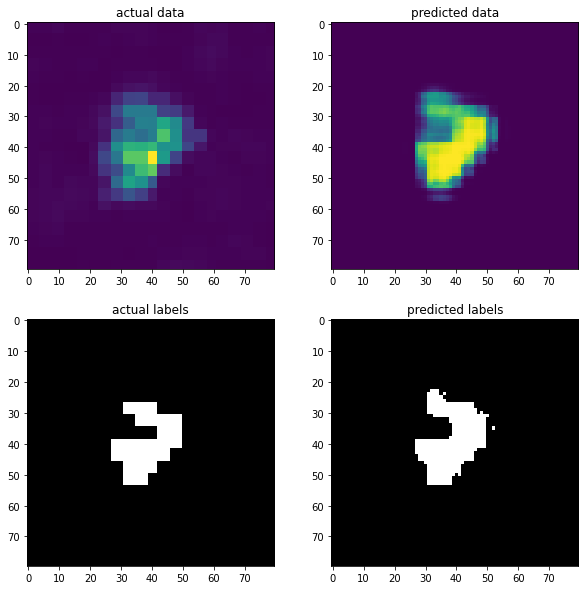

In [28]:
# visualize image samples 

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2, figsize=(10, 10)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(X_test_3d[45])
axarr[0,0].set_title('actual data')
axarr[0,1].imshow(y_pred_3d[45])  
axarr[0,1].set_title('predicted data')
axarr[1,0].imshow(y_test_3d[45], cmap="gray")
axarr[1,0].set_title('actual labels')
axarr[1,1].imshow(y_pred_bool[45], cmap="gray") 
axarr[1,1].set_title('predicted labels')

### Dwawing a Bounding Box around the image

For this purpose, let's downscale the images to its original 21x21 size

In [145]:
dsize = (21,21)
y_pred_orig_size =  np.array([im_resize(image, interpolation=cv2.INTER_NEAREST) for image in y_pred_3d])
y_pred_bool_orig_size =  np.array([im_resize(image, interpolation=cv2.INTER_NEAREST) for image in y_pred_bool])

<Figure size 432x288 with 0 Axes>

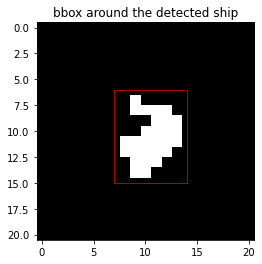

In [165]:
def bbox_draw(im_array):
    '''Draw rectangle box around the detected ship''' 
    
    # get figure bounding parameters 
    indx = np.argwhere(im_array==1)
    up_b    = min([i[0] for i in indx])
    down_b  = max([i[0] for i in indx])
    left_b  = min([i[1] for i in indx])
    right_b = max([i[1] for i in indx])
    # set yp the bbox corner coordinate with 1 pixel out
    upper_left = (left_b-1,up_b-1)
    width = right_b-left_b+2
    height = down_b-up_b+2
       
    # Configure figure ploting
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, ax = plt.subplots() 
    ax.imshow(im_array,cmap="gray")
    ax.set_title('bbox around the detected ship')
    # Create a Rectangle patch
    #Rectangle((left,upper),width,height)
    rect = patches.Rectangle(
        (left_b-1,up_b-1),
        width,height,
        linewidth=0.7,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()
    
bbox_draw(y_pred_bool_orig_size[45])